In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def process_COMPAS(temp_df, is_GAN = False):
    """
    Pick columns = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 
    'juv_other_count', 'length_of_stay','race','two_year_recid', 'c_charge_degree'] 
    from the dataframe. Convert category data into numeric and remove races other 
    than Caucasian or African-American. 
    
    Input: COMPAS dataframe
    Output: 
           COMPAS dataframe after cleaning
            age_cat                    int64
            priors_count               int64
            sex_numeric                int64
            juv_fel_count              int64
            juv_misd_count             int64
            juv_other_count            int64
            c_charge_degree_numeric    int64
            length_of_stay             int64
            race                       int64
            two_year_recid             int64
    """
    # deepcopy
    df = temp_df.copy()
    
    # remove invalid/null entries
    df = df[(df['days_b_screening_arrest'] <= 30)
                & (df['days_b_screening_arrest'] >= -30)
                & (df['is_recid'] != -1)
                & (df['c_charge_degree'] != 'O')
                & (df['score_text'] != 'N/A')]
    # remove races other than Caucasian or African-American
    df = df[(df['race']=='Caucasian') | (df['race']=='African-American')]

    # calculate length_of_stay
    df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
    # the number of seconds to the unix epoch start
    df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).astype(int) / 10**9 
    # convert seconds into month
    df['length_of_stay'] /= 60 * 60 * 24 * 31
    df['length_of_stay'] = df['length_of_stay'].astype(int)
    df = df.drop_duplicates()

    # convert category data into numeric
    df['sex_numeric'] = pd.factorize(df['sex'])[0]
    df['c_charge_degree_numeric'] = pd.factorize(df['c_charge_degree'])[0]
    race = {0: 'Caucasian', 1: 'African-American'}
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    
    if is_GAN:
      # don't need to bin age
      df["age_cat"] = df["age"]
    else:
      age = {1: 'Greater than 45', 0: '25 - 45', -1: 'Less than 25'}
      df["age_cat"] = df["age_cat"].map({v: k for k, v in age.items()})

    cols = ['age_cat','priors_count','sex_numeric','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree_numeric', 'length_of_stay','race','two_year_recid']
    df = df[cols]
    
    return df

In [3]:
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df = process_COMPAS(df)

In [4]:
# Split processed data into train and test
# non_priv_data = processed_adult.drop(["gender_labs", "over_under_50k"], axis=1)
# non_priv_train, non_priv_test = train_test_split(non_priv_data, test_size=0.2, random_state=0)

# Split processed data into train and test (fixed random seed)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
non_priv_train = train_data

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid","race"], axis=1), test_data["two_year_recid"]

In [5]:
print(df.dtypes)

age_cat                    int64
priors_count               int64
sex_numeric                int64
juv_fel_count              int64
juv_misd_count             int64
juv_other_count            int64
c_charge_degree_numeric    int64
length_of_stay             int64
race                       int64
two_year_recid             int64
dtype: object


In [6]:
def compas_classification_helper(synthesizer, eps, rep, classifier, test_df, non_priv_results=False):
    """ helper function to calculate TPR_diff, FPR_diff, and F1_score for a single synthesizer, eps, rep, and classifier """
    
    # Read in the synthetic training data or use non-private data
    if non_priv_results:
        train_df = non_priv_train
    else:
        fname = f"{synthesizer}/COMPAS_{synthesizer}_eps={eps}_{rep}.csv" # typo: todo: need to fix this back to Compas
        train_df = pd.read_csv(fname, index_col=0)

    # Train the classification model
    X_train, y_train = train_df.drop(["two_year_recid","race"], axis=1), train_df["two_year_recid"]
    X_test, y_test = test_df.drop(["two_year_recid","race"], axis=1), test_df["two_year_recid"]
#     X_train, y_train = train_df.drop("label", axis=1), train_df["label"]
#     X_test, y_test = test_df.drop("label", axis=1), test_df["label"]
    if len(np.unique(y_train)) != 2:
        return None
    if classifier == "logistic":
        m = LogisticRegression(max_iter=1000, C=1., penalty="l2")
        m.fit(X_train, y_train)
    elif classifier == "forest":
        m = RandomForestClassifier(random_state=0)
        m.fit(X_train, y_train)
    else:
        raise Exception(f"Classifier {classifier} not recognized.")

    # Predict on the test set
    y_test_pred = m.predict(X_test)

    # Get the all classification metrics on the test set
    df = test_df.copy() # test_df
    df["y"] = y_test
    df["y_pred"] = y_test_pred
#     print(df.dtypes)
    TP_f = len(df[(df["race"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["race"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["race"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["race"]==1) & (df["y"]==0) & (df["y_pred"]==1)])
    TN_f = len(df[(df["race"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["race"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["race"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["race"]==1) & (df["y"]==1) & (df["y_pred"]==0)])
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)
    TPR_diff = TPR_m - TPR_f
    FPR_diff = FPR_m - FPR_f
    f1_score = (TP_f+TP_m) / (TP_f+TP_m + 0.5*(FP_f+FP_m + FN_f+FN_m))
    
    return (TPR_diff, FPR_diff, f1_score)

In [7]:
def get_compas_table_metrics(synthesizer, epsilon_list, nreps, classifier, test_df, f1_metric="median"):
    """ return median TPR_diff, FPR_diff, F1_score across all epsilons and repetitions """
    
    # Initialize lists
    tpr_diff_list = []
    fpr_diff_list = []
    f1_scores = []
    
    # Loop through the epsilon values and repetitions
    for eps in [3.0]:
        for rep in range(nreps):

            # Get the classification metrics
            results = compas_classification_helper(synthesizer, eps, rep, classifier, test_df)
            if results is not None:
                TPR_diff, FPR_diff, f1_score = results
            
                # Append metrics to lists
                tpr_diff_list.append(TPR_diff)
                fpr_diff_list.append(FPR_diff)
                f1_scores.append(f1_score)
            
    # Get medians
    tpr_diff_median = np.median(tpr_diff_list)
    fpr_diff_median = np.median(fpr_diff_list)
    if f1_metric == "median":
        f1_score_metric = np.median(f1_scores)
    elif f1_metric == "max":
        f1_score_metric = np.max(f1_scores)
    
    return tpr_diff_median, fpr_diff_median, f1_score_metric

def get_compas_plot_metrics(synthesizer, epsilon_list, nreps, classifier, test_df, f1_metric="median"):
    """ return median and std of TPR_diff, FPR_diff, F1_score for *each* epsilon value (arrays of values) """
    
    # Initialize lists
    tpr_diff_median_list = []
    fpr_diff_median_list = []
    f1_score_metrics = []
    tpr_diff_std_list = []
    fpr_diff_std_list = []
    f1_score_std_list = []
    
    # Loop through the epsilon values and repetitions
    for eps in epsilon_list:
        
        # Initialize list to hold values for each epsilon value
        tpr_diff_list = []
        fpr_diff_list = []
        f1_scores = []
        
        # Loop through the range of repetitions
        for rep in range(nreps):

            # Get the classification metrics
            results = compas_classification_helper(synthesizer, eps, rep, classifier, test_df)
            if results is not None:
                TPR_diff, FPR_diff, f1_score = results
            
                # Append metrics to lists
                tpr_diff_list.append(TPR_diff)
                fpr_diff_list.append(FPR_diff)
                f1_scores.append(f1_score)
            
        # Append medians to lists
        tpr_diff_median_list.append(np.median(tpr_diff_list))
        fpr_diff_median_list.append(np.median(fpr_diff_list))
        if f1_metric == "median":
            f1_score_metrics.append(np.median(f1_scores))
        elif f1_metric == "max":
            f1_score_metrics.append(np.max(f1_scores))
        tpr_diff_std_list.append(np.std(tpr_diff_list))
        fpr_diff_std_list.append(np.std(fpr_diff_list))
        f1_score_std_list.append(np.std(f1_scores))
        
    return tpr_diff_median_list, fpr_diff_median_list, f1_score_metrics, tpr_diff_std_list, fpr_diff_std_list, f1_score_std_list
        
def get_compas_epsilon_plots(synthesizer_list, epsilon_list, nreps, classifier, test_df, f1_metric="median", non_priv_results=True):
    """ return subplot with three plots showing graphs of TPR_diff, FPR_diff, F1_score acros epsilons for each synthesizer """
    
    # Initialize subplots
    fig, ax = plt.subplots(1, 3, figsize=(16,5))
    
    # Loop through the synthesizers
    for synth in synthesizer_list:
        
        # Get all classification metrics
        tpr_diff_median_list, fpr_diff_median_list, f1_score_metrics, tpr_diff_std_list, fpr_diff_std_list, f1_score_std_list \
        =  get_compas_plot_metrics(synth, epsilon_list, nreps, classifier, test_df, f1_metric)
        
        # Plot the metrics with error bars
        ax[0].errorbar(epsilon_list, tpr_diff_median_list, tpr_diff_std_list, label=synth)
        ax[1].errorbar(epsilon_list, fpr_diff_median_list, fpr_diff_std_list, label=synth)
        ax[2].errorbar(epsilon_list, f1_score_metrics, f1_score_std_list, label=synth)
        
    # Add the non-private results to the plots
    non_priv_tpr_diff, non_priv_fpr_diff, non_priv_f1_score = compas_classification_helper(None, None, None, classifier, test_df, non_priv_results=True)
    ax[0].hlines(non_priv_tpr_diff, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
    ax[1].hlines(non_priv_fpr_diff, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
    ax[2].hlines(non_priv_f1_score, xmin=epsilon_list[0], xmax=epsilon_list[-1], linestyles="--", label="Non-private data")
        
    # Plotting details
    for i in range(3):
        ax[i].set_xlabel("Privacy budget")
        ax[i].legend()
    ax[0].set_ylabel("Equalized odds distance ($y=1$)")
    ax[1].set_ylabel("Equalized odds distance ($y=0$)")
    ax[2].set_ylabel("F1-score")
    if classifier == "logistic":
        title = f"Compas classification summary (logistic regression)"
    elif classifier == "forest":
        title = f"Compas classification summary (random forest)"
    fig.suptitle(title, size=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
epsilons = np.linspace(1,5,5)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
non_priv_train = train_data
non_priv_test = test_data

# Split test data into X and y
x_test, y_test = test_data.drop(["two_year_recid", 'race'], axis=1), test_data["two_year_recid"]

In [9]:
for synthesizer in ["MWEM", "MWEMQUAIL", "DPCTGAN", "PATECTGAN", "DPCTGANQUAIL", "PATECTGANQUAIL"]:
    print(synthesizer)
    for classifier, name in zip(["logistic", "forest"], ["Logistic Regression", "Random Forest"]):
        print(name + ":")
        tpr_diff_median, fpr_diff_median, f1_score_median = get_compas_table_metrics(synthesizer, epsilon_list=epsilons, nreps=15, classifier=classifier, test_df=test_data)
        print(f"TPR difference median: {tpr_diff_median:f}")
        print(f"FPR difference median: {fpr_diff_median:f}")
        print(f"F1-score median: {f1_score_median:f}")
    print()

MWEM
Logistic Regression:
TPR difference median: 0.011054
FPR difference median: 0.023593
F1-score median: 0.176962
Random Forest:
TPR difference median: 0.017734
FPR difference median: 0.021885
F1-score median: 0.439294

MWEMQUAIL
Logistic Regression:
TPR difference median: 0.227484
FPR difference median: 0.164097
F1-score median: 0.547131
Random Forest:
TPR difference median: 0.196787
FPR difference median: 0.144856
F1-score median: 0.543897

DPCTGAN
Logistic Regression:
TPR difference median: 0.000000
FPR difference median: 0.000000
F1-score median: 0.604125
Random Forest:
TPR difference median: 0.000000
FPR difference median: 0.000000
F1-score median: 0.609788

PATECTGAN
Logistic Regression:
TPR difference median: -0.003300
FPR difference median: 0.000000
F1-score median: 0.614173
Random Forest:
TPR difference median: -0.028411
FPR difference median: 0.006550
F1-score median: 0.516640

DPCTGANQUAIL
Logistic Regression:
TPR difference median: 0.151636
FPR difference median: 0.096301

In [10]:
# non-private data
print("Original Dataset")
print("Logistic Regression:")
non_priv_tpr_diff, non_priv_fpr_diff, non_priv_f1_score = compas_classification_helper("", [], 0, "logistic", test_data, non_priv_results=True)
print(f"TPR difference median: {non_priv_tpr_diff:f}")
print(f"FPR difference median: {non_priv_fpr_diff:f}")
print(f"F1-score: {non_priv_f1_score:f}")

print("Random Forest:")
non_priv_tpr_diff, non_priv_fpr_diff, non_priv_f1_score = compas_classification_helper("", [], 0, "forest", test_data, non_priv_results=True)
print(f"TPR difference median: {non_priv_tpr_diff:f}")
print(f"FPR difference median: {non_priv_fpr_diff:f}")
print(f"F1-score: {non_priv_f1_score:f}")

Original Dataset
Logistic Regression:
TPR difference median: 0.338642
FPR difference median: 0.171700
F1-score: 0.566411
Random Forest:
TPR difference median: 0.283848
FPR difference median: 0.119157
F1-score: 0.580858


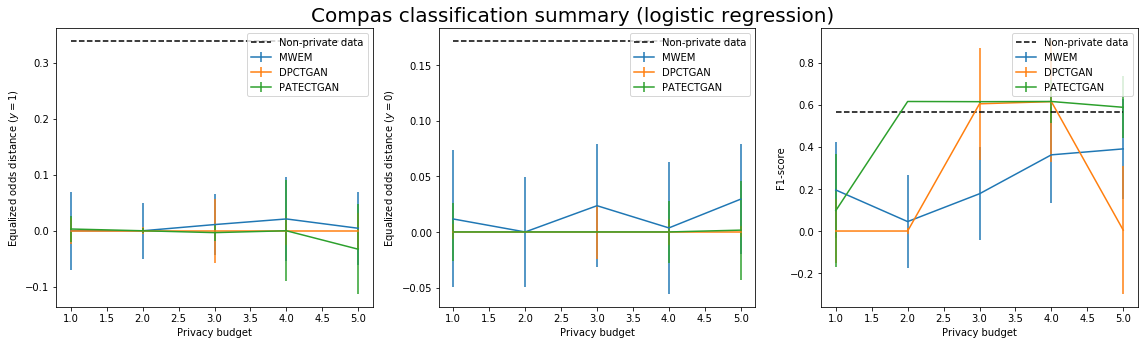

In [16]:
get_compas_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_list=epsilons, nreps=15, classifier="logistic", test_df=non_priv_test, f1_metric="median", non_priv_results=True)


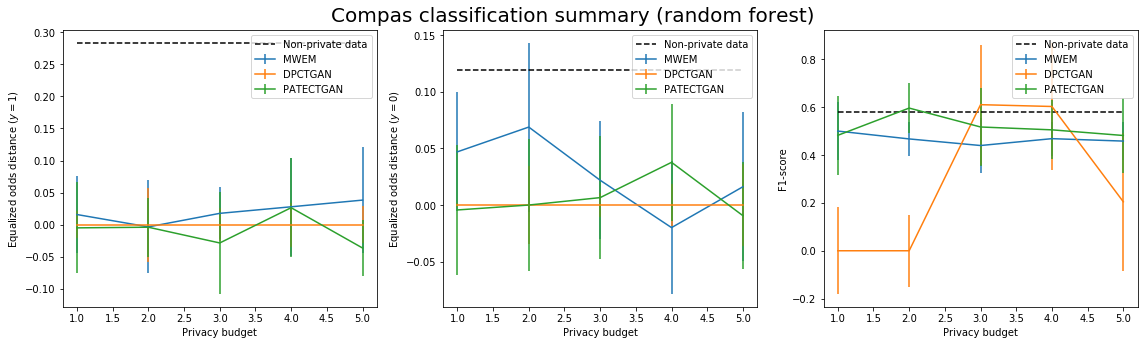

In [17]:
get_compas_epsilon_plots(["MWEM", "DPCTGAN", "PATECTGAN"], epsilon_list=epsilons, nreps=15, classifier="forest", test_df=non_priv_test, f1_metric="median", non_priv_results=True)


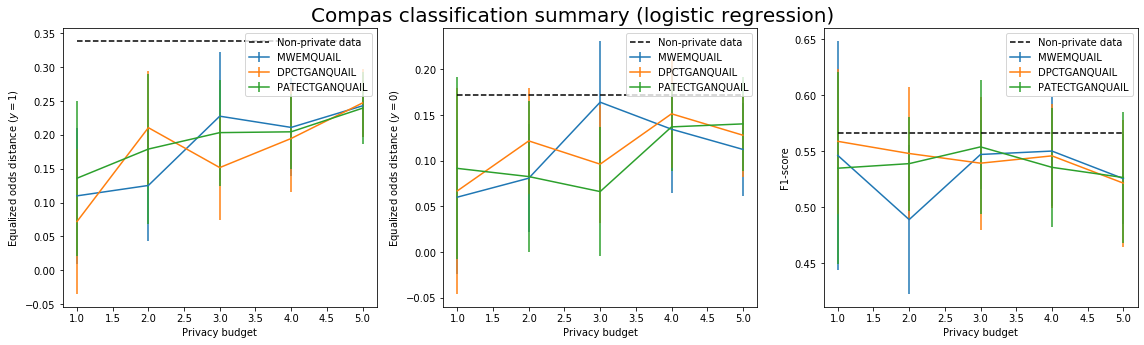

In [18]:
# Plot classification summary for logistic regression
get_compas_epsilon_plots(["MWEMQUAIL", "DPCTGANQUAIL", "PATECTGANQUAIL"], epsilon_list=epsilons, nreps=15, classifier="logistic", test_df=non_priv_test, f1_metric="median", non_priv_results=True)


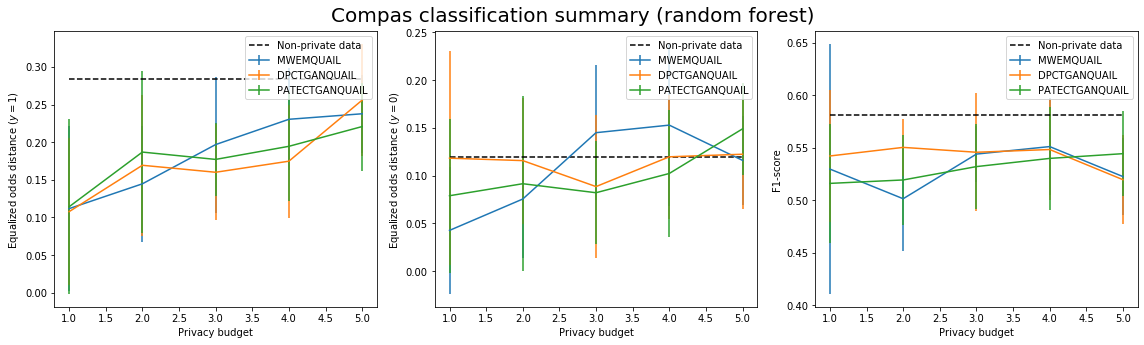

In [19]:
# Plot classification summary for random forest
get_compas_epsilon_plots(["MWEMQUAIL", "DPCTGANQUAIL", "PATECTGANQUAIL"], epsilon_list=epsilons, nreps=15, classifier="forest", test_df=non_priv_test, f1_metric="median", non_priv_results=True)